In [84]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import diffrax
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, PIDController
import equinox as eqx
import optax
from typing import Callable, List
import scipy
from tqdm.autonotebook import tqdm

### Non-constant a(r) and j(r)

As a start I set j to some value at r=r_min (0 everywhere else), to mimic a star.
Additionally a(r) will be chosen from a distribution of analytical monotonically decreasing functions (I'll start with the family of $f(r) = K * r^p$) with  $r_1<r<r_2$ ) (additionally some noise can be added)

In [85]:
# data creation

def create_data_spherical_symmetry_nonconstant(
        r_min: jnp.ndarray, 
        r_max: jnp.ndarray, 
        I0: jnp.ndarray, 
        stepsize: jnp.ndarray, 
        K: jnp.ndarray,
        p: jnp.ndarray,
        j_star: jnp.ndarray):
    
    def a(r, K, p):
        return K*r**p

    def j(r, j_star):
        if r == r_min:
            return j_star
        else:
            return 0


    def rt_spherical_symmetry_ode(r, I, args):  
        a_value = args[0]*(r**args[1])
        j_value = args[2] #this value is used if r == r_min
        def case1(I):
            return -(a_value/2 + 1/r)*I +j_value/2

        def case2(I):
            return -(a_value/2 + 1/r)*I 
        
        return jax.lax.cond(r == 0, case1, case2, I)
    
    
    solver = Dopri5()
    stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)
    term = ODETerm(rt_spherical_symmetry_ode)
        
    def solve_one(r0, r1, I_start, K, p, j_star):
        r_values =  SaveAt(ts=jnp.linspace(r0, r1, 1000)) #wenn saveat immer zwischen bestimmten Werten sein soll unabhängig von r0 und r1, den Teil hier noch ändern (checken, ob das noch geht wenn Starting condition nicht am Anfang des Intervalls)
        sol = diffeqsolve(term, solver, t0=r0, t1=r1, dt0=stepsize, y0=I_start,  
                          stepsize_controller=stepsize_controller, saveat=r_values, args=(K,p, j_star))   
        return sol.ts, sol.ys
        
    batched_solve = jax.vmap(solve_one, in_axes=(0, 0, 0, 0, 0, 0))
    all_rs, all_Is = batched_solve(r_min, r_max, I0, K, p, j_star)
    all_rs = all_rs[:, jnp.newaxis, :]
    all_Is = all_Is[:, jnp.newaxis, :]
    all_data = jnp.concatenate((all_rs, all_Is), axis=1)

    return all_data   

In [86]:
# arrays for different starting values -> keep in mind to not use r0 = 0
r0s = jnp.ones(1000)
r1s = 10.0 * jnp.ones(1000)  #für hohe r konvergiert jedes I gegen j/a (also wenn r1s bspw 1000. * jnp.ones(1000)) dann werden alle irgendwann konst
I0s = jnp.ones(1000)

#random values for a and j and I0
key = jax.random.PRNGKey(42)
key1, key2, key3 = jax.random.split(key, 3) 
Ks = jax.random.uniform(key1, shape=(1000,))
ps = jax.random.uniform(key2, shape=(1000,), minval=-2, maxval=-1)
j_stars = jax.random.uniform(key3, shape=(1000,))

# noch fragen, ob auch bestimmte Werte für j und K 


training_data = create_data_spherical_symmetry_nonconstant(r0s, r1s, I0s, 0.1, Ks, ps, j_stars)

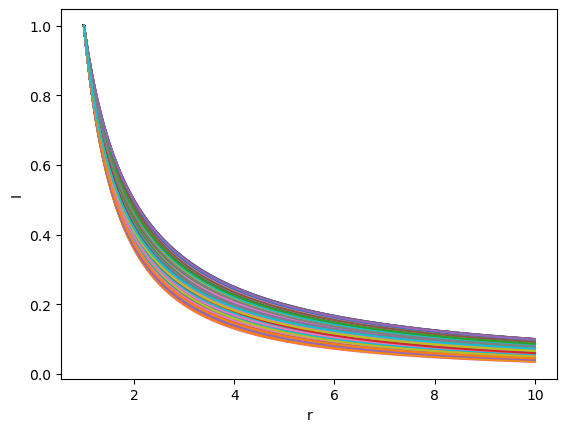

In [87]:
for i in range(len(training_data)):
    plt.plot(training_data[i][0], training_data[i][1])

plt.xlabel('r')
plt.ylabel('I')
plt.show()

In [88]:
r_shape_corrected = training_data[:,0,:][:,jnp.newaxis,:]
a_shape_corrected = r_shape_corrected**ps[:, jnp.newaxis, jnp.newaxis] * Ks[:, jnp.newaxis, jnp.newaxis]
j_shape_corrected = jnp.zeros_like(r_shape_corrected)
j_shape_corrected = j_shape_corrected.at[:, 0, 0].set(j_stars)
input_function = jnp.concatenate((r_shape_corrected, a_shape_corrected, j_shape_corrected), axis=1)
#falls I0 nicht immer konstant wäre entweder Lösungen normieren oder hier als Starting conidition (vllt 1000 mal wiederholt einfach) miteinbringen, oder anders

I_shape_corrected = training_data[:,1,:][:,jnp.newaxis,:]

# ADD NOISE  - das noch machen

In [89]:
train_x, test_x = input_function[:800], input_function[800:1000] 
train_y, test_y = I_shape_corrected[:800], I_shape_corrected[800:1000]


In [90]:
#def FNO

In [91]:
class SpectralConv1d(eqx.Module):
    real_weights: jax.Array
    imag_weights: jax.Array
    in_channels: int
    out_channels: int
    modes: int

    def __init__(
            self,
            in_channels,
            out_channels,
            modes,
            *,
            key,
    ):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes

        scale = 1.0 / (in_channels * out_channels)

        real_key, imag_key = jax.random.split(key)
        self.real_weights = jax.random.uniform(
            real_key,
            (in_channels, out_channels, modes),
            minval=-scale,
            maxval=+scale,
        )
        self.imag_weights = jax.random.uniform(
            imag_key,
            (in_channels, out_channels, modes),
            minval=-scale,
            maxval=+scale,
        )

    #im Fourierraum entspricht die Faltung einfach einer Multiplikation mit einem Filter, sprich wir multiplizieren einfach mit den Filterkoeffizienten (ohne Summe darüner natürlich)
    #analog wie bei CNNs macht man dann Summe über input channels (oder halt andere Aggregation evtl.) und dann für jeden output channel andere Koeffizienten und deswegen 
    #ist die output dim dann o,M     
    def complex_mult1d(
            self,
            x_hat,
            w,
    ):
        return jnp.einsum("iM,ioM->oM", x_hat, w)  #Summe über i, also die input channels
    
    def __call__(
            self,
            x,
    ):
        channels, spatial_points = x.shape

        # shape of x_hat is (in_channels, spatial_points//2+1)
        x_hat = jnp.fft.rfft(x)
        # shape of x_hat_under_modes is (in_channels, self.modes)
        x_hat_under_modes = x_hat[:, :self.modes]
        weights = self.real_weights + 1j * self.imag_weights
        # shape of out_hat_under_modes is (out_channels, self.modes)
        out_hat_under_modes = self.complex_mult1d(x_hat_under_modes, weights)

        # shape of out_hat is (out_channels, spatial_points//2+1)
        out_hat = jnp.zeros(
            (self.out_channels, x_hat.shape[-1]),
            dtype=x_hat.dtype
        )
        out_hat = out_hat.at[:, :self.modes].set(out_hat_under_modes)

        out = jnp.fft.irfft(out_hat, n=spatial_points)

        return out



In [92]:
class FNOBlock1d(eqx.Module):
    spectral_conv: SpectralConv1d
    bypass_conv: eqx.nn.Conv1d
    activation: Callable

    def __init__(
            self,
            in_channels,
            out_channels,
            modes,
            activation,
            *,
            key,
    ):
        spectral_conv_key, bypass_conv_key = jax.random.split(key)
        self.spectral_conv = SpectralConv1d(
            in_channels,
            out_channels,
            modes,
            key=spectral_conv_key,
        )
        #vllt fragen: in Paper steht eig, dass zusätzlich einfach affine Trafo und hier jetzt convolution 
        #convolution kann ja auch als Matrixmultiplikation gesehen werden und deswegen ist das dann einfach auch affine trafo (halt special case)?
        self.bypass_conv = eqx.nn.Conv1d(
            in_channels,
            out_channels,
            1,  # Kernel size is one
            key=bypass_conv_key,
        )
        self.activation = activation

    def __call__(
            self,
            x,
    ):
        return self.activation(
            self.spectral_conv(x) + self.bypass_conv(x)
        )

In [93]:
class FNO1d(eqx.Module):
    lifting: eqx.nn.Conv1d
    fno_blocks: List[FNOBlock1d]
    projection: eqx.nn.Conv1d

    def __init__(
            self,
            in_channels,
            out_channels,
            modes,
            width,
            activation,
            n_blocks = 4,
            *,
            key,
    ):
        key, lifting_key = jax.random.split(key)
        #lifting erhöht channel dim aber nicht spatial dim
        self.lifting = eqx.nn.Conv1d(
            in_channels,
            width,
            1,
            key=lifting_key,
        )

        self.fno_blocks = []
        for i in range(n_blocks):
            key, subkey = jax.random.split(key)  #bedeutet das, jeder Block wird gleich initialisiert, weil immer gleicher key?
            self.fno_blocks.append(FNOBlock1d(
                width,
                width,
                modes,
                activation,
                key=subkey,
            ))
        #projection umgekehrt zu lifting
        key, projection_key = jax.random.split(key)
        self.projection = eqx.nn.Conv1d(
            width,
            out_channels,
            1,
            key=projection_key,
        )
    def __call__(
            self,
            x,
    ):
        x = self.lifting(x)

        for fno_block in self.fno_blocks:
            x = fno_block(x)

        x = self.projection(x)

        return x

In [94]:
fno = FNO1d(
    3,
    1,
    16,
    64,
    jax.nn.relu,
    key=jax.random.PRNGKey(0),
)

In [95]:
def dataloader(
    key,
    dataset_x,
    dataset_y,
    batch_size,
):
    n_samples = dataset_x.shape[0]

    n_batches = int(jnp.ceil(n_samples / batch_size))

    permutation = jax.random.permutation(key, n_samples)

    for batch_id in range(n_batches):
        start = batch_id * batch_size
        end = min((batch_id + 1) * batch_size, n_samples)

        batch_indices = permutation[start:end]

        yield dataset_x[batch_indices], dataset_y[batch_indices]

In [96]:
def loss_fn(model, x, y):
    y_pred = jax.vmap(model)(x)
    loss = jnp.mean(jnp.square(y_pred - y))
    return loss

optimizer = optax.adam(3e-4)
opt_state = optimizer.init(eqx.filter(fno, eqx.is_array))

@eqx.filter_jit   #was bedeutet das?
def make_step(model, state, x, y):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model, x, y)
    val_loss = loss_fn(model, test_x[..., ::32], test_y[..., ::32])  #vllt noch anpassen
    updates, new_state = optimizer.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss, val_loss

loss_history = []
val_loss_history = []

shuffle_key = jax.random.PRNGKey(10)
for epoch in tqdm(range(300)):
    shuffle_key, subkey = jax.random.split(shuffle_key)
    for (batch_x, batch_y) in dataloader(
        subkey,
        train_x[..., ::32],   #vllt noch anpassen
        train_y[..., ::32],
        batch_size=100,
    ):
        fno, opt_state, loss, val_loss = make_step(fno, opt_state, batch_x, batch_y)
        loss_history.append(loss)
        val_loss_history.append(val_loss)

  0%|          | 0/300 [00:00<?, ?it/s]

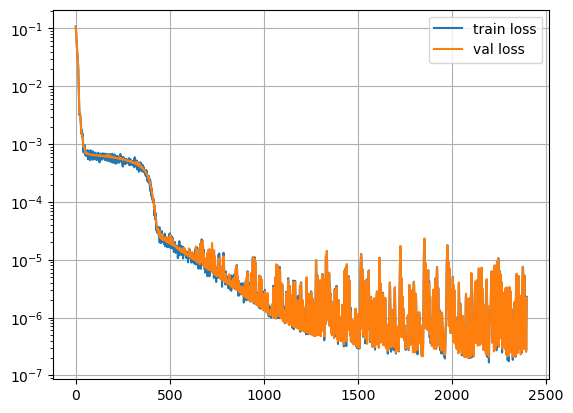

In [97]:
plt.plot(loss_history, label="train loss")
plt.plot(val_loss_history, label="val loss")
plt.legend()
plt.yscale("log")
plt.grid()

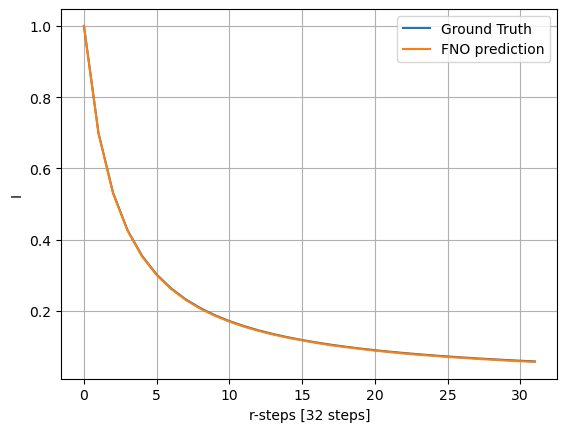

In [98]:
plt.plot(test_y[1, 0, ::32], label="Ground Truth")
plt.plot(fno(test_x[1, :, ::32])[0], label="FNO prediction")
plt.legend()
plt.xlabel('r-steps [32 steps]')
plt.ylabel('I')
plt.grid()

I'm now trying to check for different values of p if the predictions works

In [105]:

r0s = jnp.ones(10)
r1s = 10.0 * jnp.ones(10) 
I0s = jnp.ones(10)
Ks = jnp.ones(10)
j_stars = jnp.ones(10)
ps = jnp.linspace(-2, -1, 10)

data_check = create_data_spherical_symmetry_nonconstant(r0s, r1s, I0s, 0.1, Ks, ps, j_stars)

In [106]:
y_check = data_check[:,1,:][:,jnp.newaxis,:]

r_check = data_check[:,0,:][:,jnp.newaxis,:]
a_check = r_check**ps[:, jnp.newaxis, jnp.newaxis] * Ks[:, jnp.newaxis, jnp.newaxis]
j_check = jnp.zeros_like(r_check)
j_check= j_check.at[:, 0, 0].set(j_stars)
x_check = jnp.concatenate((r_check, a_check, j_check), axis=1)


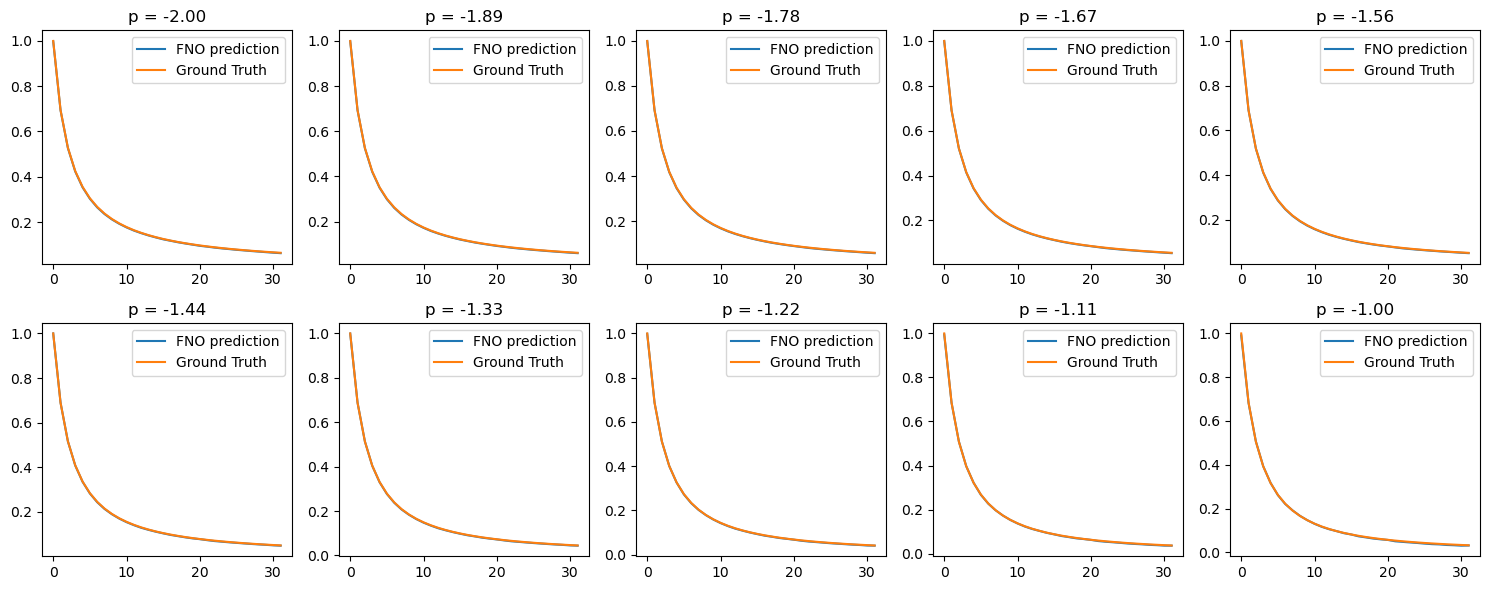

In [107]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  
for i in range(10):
    ax = axes[i // 5, i % 5] 
    y1 = fno(x_check[i, :, ::32])[0]
    y2 = y_check[i, 0, ::32]
    ax.plot(y1, label="FNO prediction")
    ax.plot(y2, label="Ground Truth")
    ax.set_title(f"p = {-2 + i* 0.11111111:.2f}")
    ax.legend(loc='best')
    

plt.tight_layout()  
plt.show()